Import Necessary Libraries

In [34]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


Load the Data

In [35]:
# Load datasets
train = pd.read_csv(r'D:\CurrentWork\TitanicSurvival\Data\train.csv')
test = pd.read_csv(r'D:\CurrentWork\TitanicSurvival\Data\test.csv')

# Display first few rows
print("Training Data:")
print(train.head())

print("\nTest Data:")
print(test.head())


Training Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

Data Preprocessing and Feature Engineering

Handle Missing Values

In [36]:
# Fill missing Age with median
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

# Fill missing Embarked in train with mode
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Fill missing Fare in test with median
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# Drop Cabin as it has many missing values
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)


Feature Engineering

In [37]:
# Extract Title from Name
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify Titles
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                               'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Create FamilySize feature
for dataset in [train, test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create IsAlone feature
for dataset in [train, test]:
    dataset['IsAlone'] = 1  # Initialize to 1 (means alone)
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0

# Drop unnecessary columns
train.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
test.drop(['Name', 'Ticket'], axis=1, inplace=True)


Encode Categorical Variables

In [38]:
# Identify categorical features
categorical_features = ['Sex', 'Embarked', 'Title']

# One-Hot Encode categorical variables
train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)


Align Train and Test Features

In [39]:
# Separate features and target
X = train.drop('Survived', axis=1)
y = train['Survived']

# Align the train and test data (ensure same columns)
X, test = X.align(test, join='left', axis=1, fill_value=0)


Feature Scaling

In [40]:
# Initialize StandardScaler
scaler = StandardScaler()

# Features to scale
scale_features = ['Age', 'Fare', 'FamilySize', 'IsAlone']

# Fit and transform the training data
X[scale_features] = scaler.fit_transform(X[scale_features])

# Transform the test data
test[scale_features] = scaler.transform(test[scale_features])


 Split Data into Features and Target

In [41]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}")


Training Set: (712, 14), Validation Set: (179, 14)


Build and Tune the Logistic Regression Model

In [42]:
# Define the pipeline
pipeline = Pipeline([
    ('clf', LogisticRegression(solver='liblinear'))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'clf__penalty': ['l1', 'l2'],               # Regularization type
    'clf__class_weight': [None, 'balanced']     # Handle class imbalance
}

# Initialize GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid.fit(X_train, y_train)

# Display the best parameters and best score
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")


Best Parameters: {'clf__C': 10, 'clf__class_weight': None, 'clf__penalty': 'l1'}
Best Cross-Validation Accuracy: 0.8175


Evaluate the Model

Validation Accuracy: 0.8547


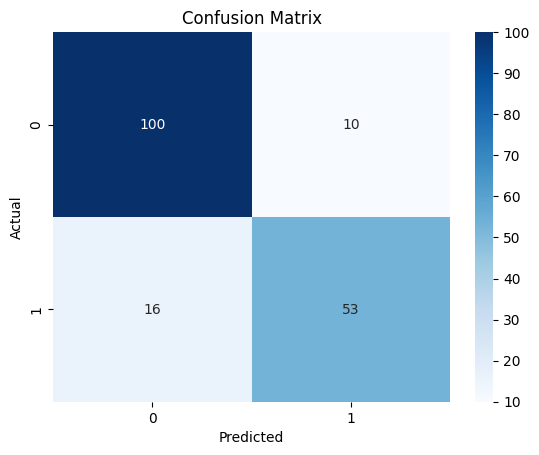

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       110
           1       0.84      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [43]:
# Predict on validation set using the best estimator
y_pred = grid.best_estimator_.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_val, y_pred))


 Feature Importance Analysis

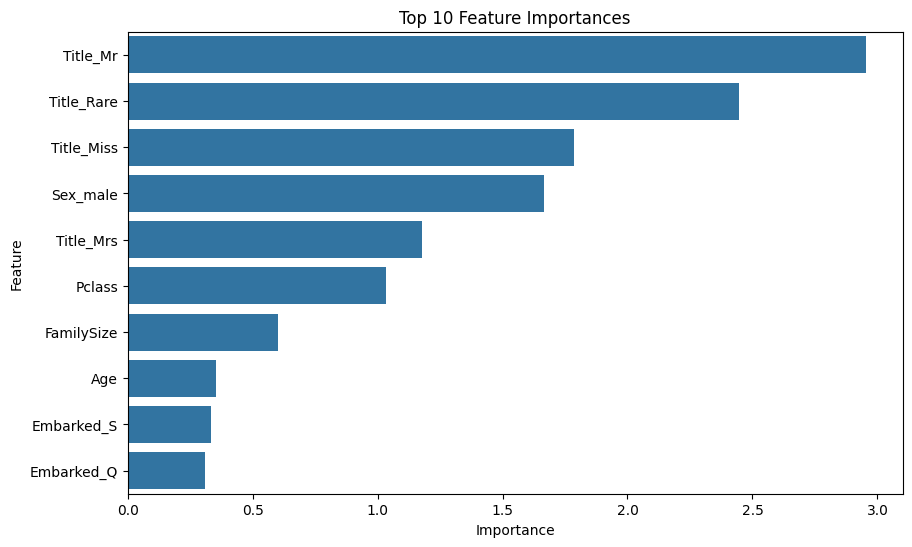

In [44]:
# Get the coefficients from the Logistic Regression model
coefficients = grid.best_estimator_.named_steps['clf'].coef_[0]
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate absolute coefficients for importance
feature_importance['Importance'] = feature_importance['Coefficient'].abs()

# Sort by importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.show()


 Make Predictions on Test Data and Create Submission File

In [45]:
# Retrain the model on the entire training data
final_model = grid.best_estimator_
final_model.fit(X, y)

# Predict on test data
test_predictions = final_model.predict(test)

# Load PassengerId for submission
test_passenger_ids = pd.read_csv(r'D:\CurrentWork\TitanicSurvival\Data\test.csv')['PassengerId']

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_predictions
})

# Save to CSV
submission.to_csv('titanic_logistic_regression_submission.csv', index=False)

print("Submission file 'titanic_logistic_regression_submission.csv' created successfully!")


Submission file 'titanic_logistic_regression_submission.csv' created successfully!
